<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Fundamental Factors](Introduction.ipynb) › Lesson 6: Profitability
***

# Analyzing Profitability with Alphalens

After performing exploratory data analysis (EDA) on a fundamental factor, a common next step is to use Alphalens to analyze the factor's predictive value. Alphalens is a useful tool for preliminary research because we don't have to write much code to get feedback on whether the factor may be predictive. It provides a low-effort way to experiment and gain direction regarding next steps. 

To analyze the profitability factor, we first construct our operating margin factor, incorporating the filtering and truncation rules that came to light during EDA:

In [1]:
from zipline.pipeline import Pipeline, sharadar

fundamentals = sharadar.Fundamentals.slice('ART')

revenue = fundamentals.REVENUE.latest
operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

# exclude companies with negative operating expenses or negative cost of revenue
opex = fundamentals.OPEX.latest
cor = fundamentals.COR.latest
operating_margin = operating_margin.where((opex > 0) & (cor > 0))

# clip range to (-1, 1) so as not to overweight outliers
operating_margin = operating_margin.clip(min_bound=-1, max_bound=1)


We import our universe filters to use in the pipeline, but we go further and explicitly limit our universe to companies with non-null operating margins. That is, we exclude from the pipeline output the records we masked with `NaN`s (such as companies with zero revenue). If we pass too many `NaN` values to Alphalens, Alphalens will get worried and complain that it had to drop too many records from the analysis; we can avoid this by not passing the intentional `NaN`s to Alphalens in the first place.  

In [2]:
from codeload.fundamental_factors.universe import CommonStocks, BaseUniverse

universe = BaseUniverse() & operating_margin.notnull()

A useful feature of Alphalens is the ability to include secondary grouping factors in the analysis. Grouping factors result in additional plots that break down the primary factor's performance by the grouping factor. You can include as many grouping factors as you like. 

Because our base universe includes companies of all sizes, it is usually a good idea to include size as a grouping factor. Company size, particularly when the very smallest of companies are included in the universe, can have a significant impact on performance, which can potentially mask the effect of the factor you're trying to study. Including size as a grouping factor allows you to spot when this is happening.

To group by size, we'll add a market cap column to our operating margin pipeline. Note that we use the `quantiles()` method to bucket the universe into 5 quantiles by market cap. When using Alphalens, you typically want the primary factor to be a continuous variable, but the grouping factors should be bucketed into discrete variables (usually using `quantiles()`). Alphalens will show us the primary factor's performance for each market cap bucket, which means there should be a limited number of buckets, as we don't want to create a performance graph for every individual market cap value. 

In [3]:
marketcap = fundamentals.MARKETCAP.latest

pipeline = Pipeline(
    columns={
        'profitability': operating_margin,
        'size': marketcap.quantiles(5, mask=universe) 
    },
    initial_universe=CommonStocks(),
    screen=universe
)

To create a tear sheet, we pass the pipeline object to the Alphalens `from_pipeline()` function. While this doesn't require writing much code, some understanding of the parameters is required in order to achieve the best results for any given factor. In this example, note the following points:

* `start_date`: the Sharadar data starts at the beginning of 1998. But we must set the Alphalens `start_date` one month later than that to accomodate the 21-day (1 month) lookback windows in our base universe definition. In general, the Alphalens `start_date` should accommodate the longest lookback window in your pipeline definition.
* `end_date`: the pipeline will be run through the end date, and forward returns will then be calculated in accordance with the `periods` argument. Therefore, you must set the `end_date` early enough so that there is sufficient data in the bundle after that date for calculating forward returns. In this case, we are asking Alphalens to calculate forward returns up to 21 days out, which means the `end_date` should be at least 21 trading days before the latest date in the bundle data. 
* `periods`: we instruct Alphalens to calculate 1-day, 5-day (1 week), and 21-day (approx. 1 month) forward returns to assess the factor's predictive value. Usually, results will be similar for all 3 forward return periods. 
* `factor`: this should be the pipeline column name of the factor we want to analyze. In this case, we named the pipeline column "profitability".
* `quantiles`: this tells Alphalens how many equal-sized buckets to split the profitability factor into.
* `zero_aware`: we can set this parameter to True for operating margin since zero is the dividing line between profitable and unprofitable companies. This will cause Alphalens to put positive and negative values in separate buckets and construct a long/short portfolio from the positives and negatives, respectively. Since we set `quantiles` to 4, there will be 2 buckets for negative values and 2 buckets for positive values. 
* `groupby`: this should be a pipeline column name, or a list of pipeline column names, containing the factor(s) we want to group by. In this example we are grouping by market cap, which we named "size" in the pipeline definition.
* `segment`: if you want to analyze more than a few years of data, use `segment='Y'` to instruct Alphalens to run the analysis in 1-year chunks to keep memory usage low. Analyzing large date ranges helps avoid the potentially misleading effects of temporary market regimes on a factor's performance. However, as large date ranges can take awhile to run, it may be beneficial to first run a shorter date range to sanity-check the results.

Commentary on the Alphalens output is provided after the tear sheet.

,min,max,mean,std,count,avg daily count,count %
Profitability Quantile,,,,,,,
1,-1.000,-0.096,-0.658,0.326,"2,680,123",427.4,13.3%
2,-0.378,-0.000,-0.070,0.060,"2,676,938",426.9,13.3%
3,0.000,0.126,0.056,0.029,"7,422,515",1183.6,36.7%
4,0.092,0.965,0.234,0.136,"7,419,376",1183.1,36.7%


,1D,21D,5D
Ann. alpha,0.070,0.096,0.083
beta,-0.041,-0.258,-0.152
Mean Relative Return Top Quantile (bps),0.185,0.272,0.237
Mean Relative Return Bottom Quantile (bps),-3.328,-3.319,-3.299
Mean Spread (bps),3.513,4.088,3.823


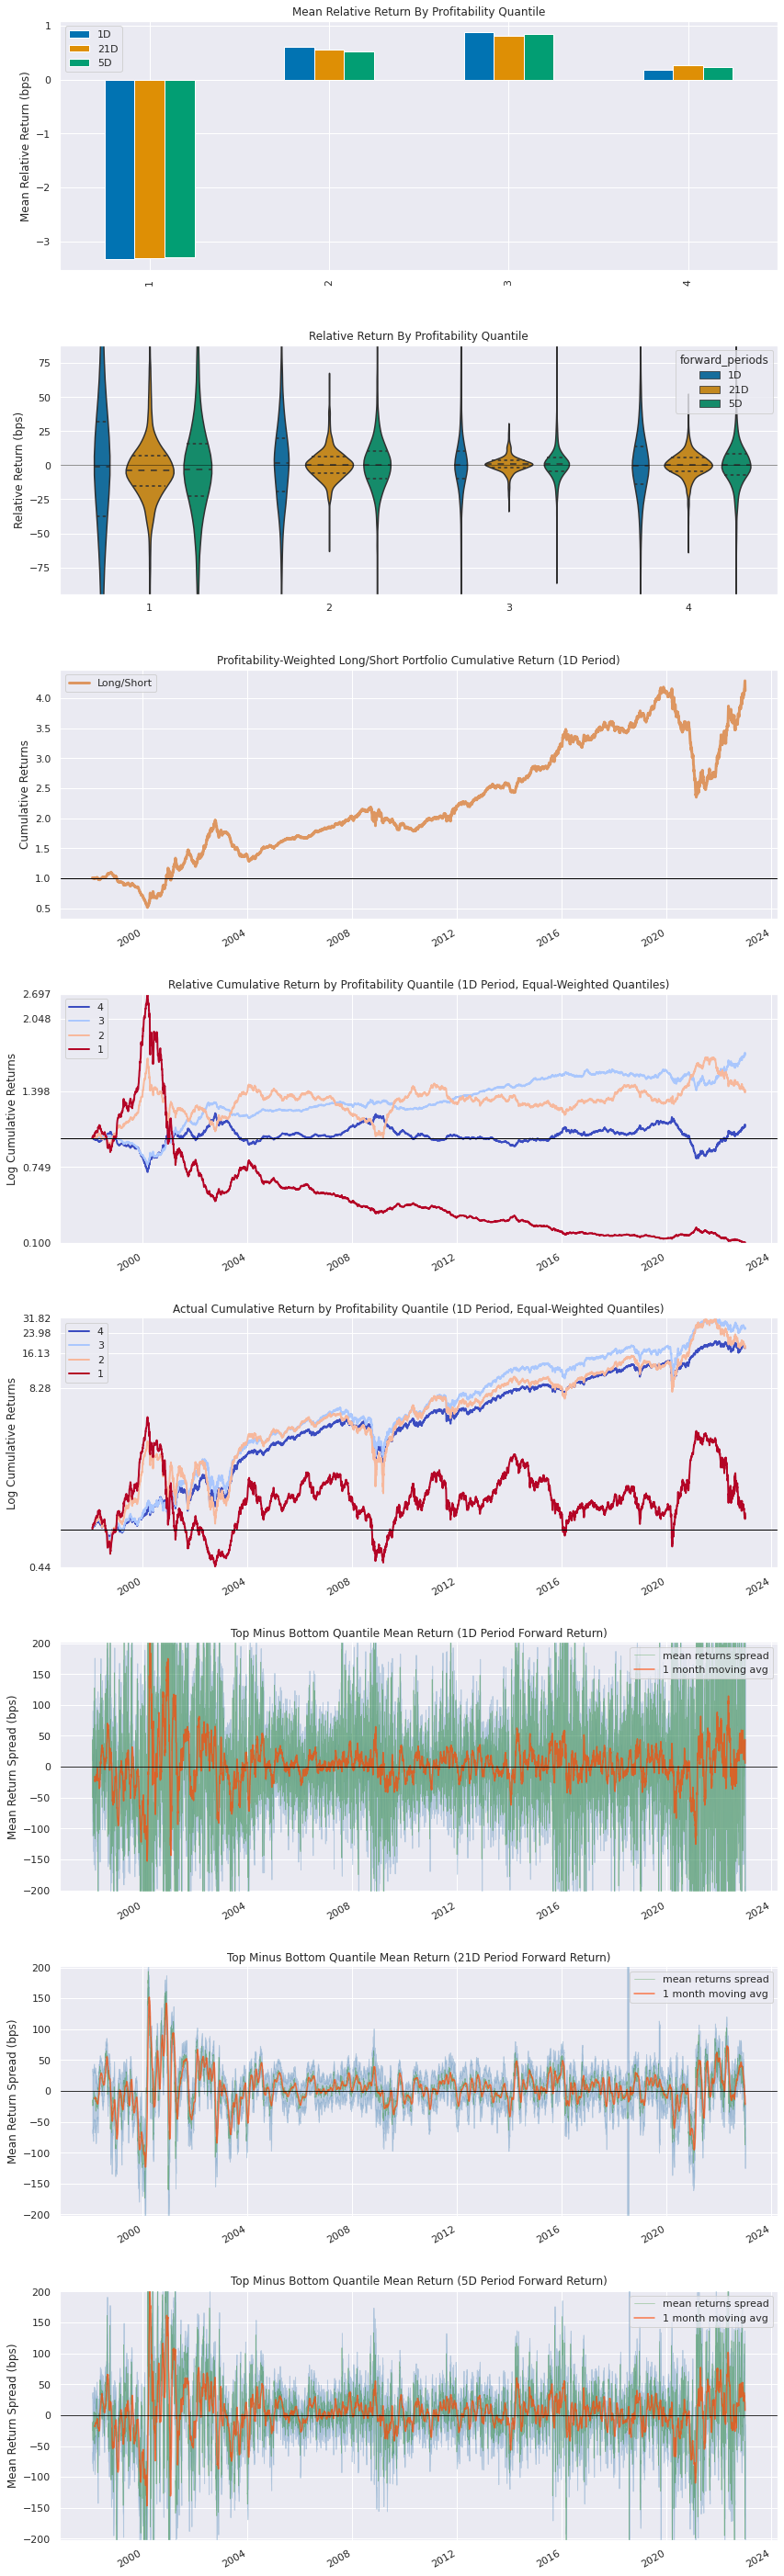

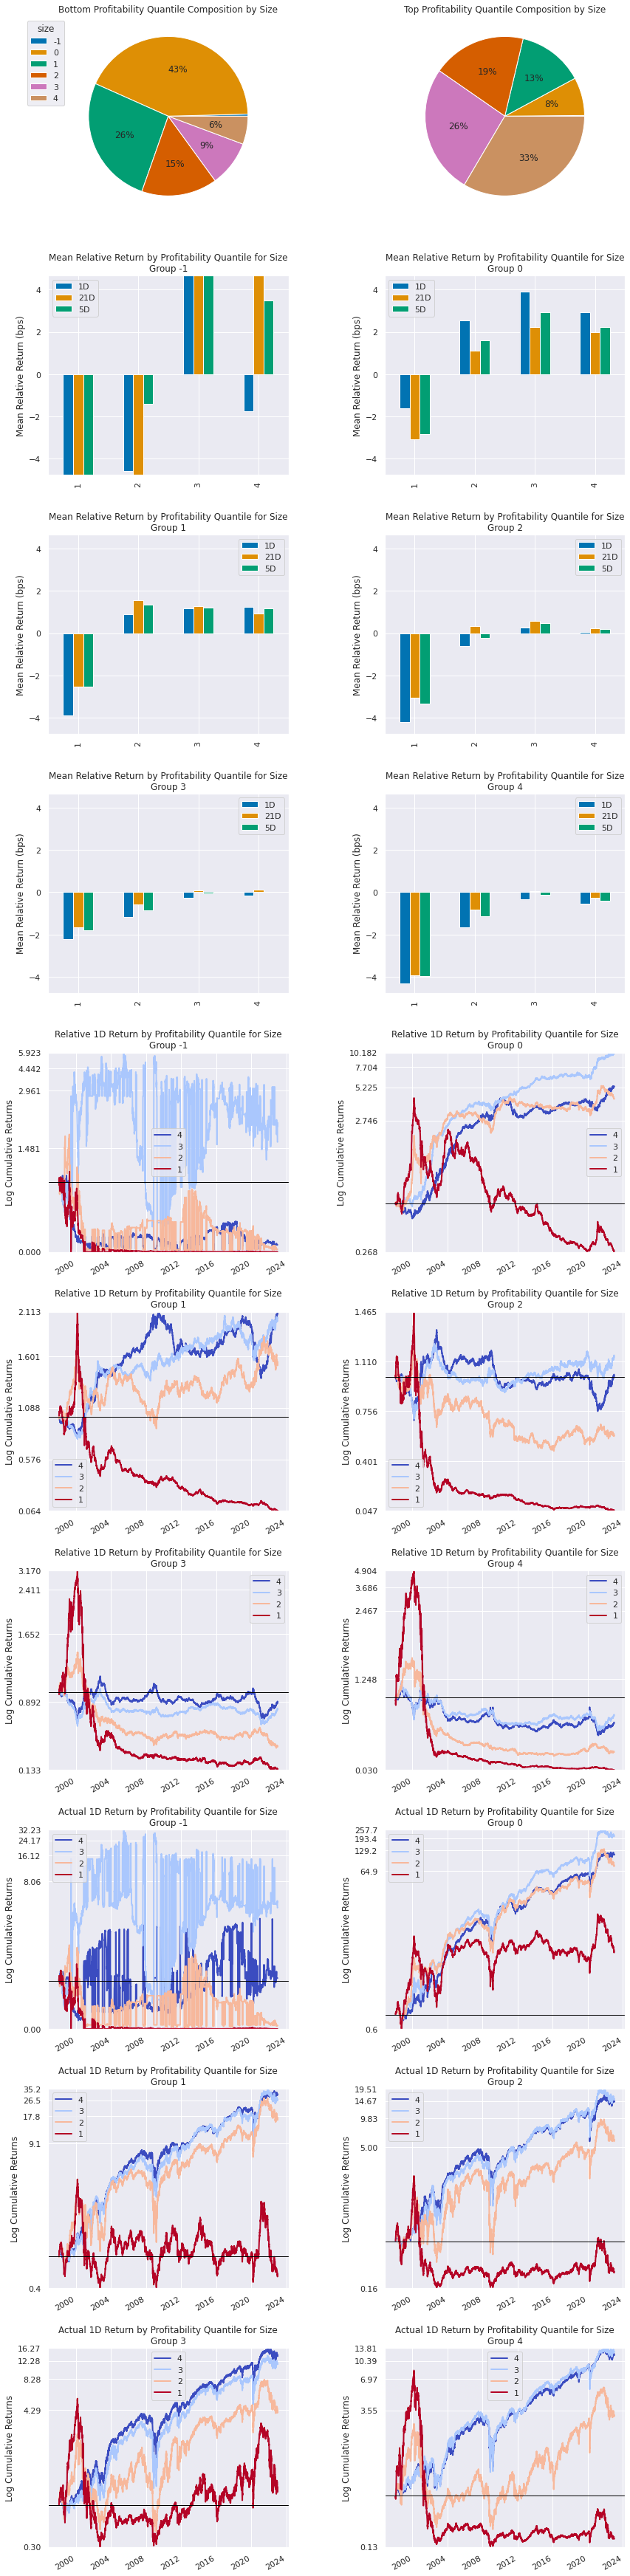

,1D,21D,5D
IC Mean,0.025,0.052,0.037
IC Std.,0.091,0.128,0.107
Risk-Adjusted IC,0.276,0.403,0.346
t-stat(IC),21.838,31.950,27.429
p-value(IC),0.000,0.000,0.000
IC Skew,0.160,0.194,0.210
IC Kurtosis,1.178,0.579,0.851


/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


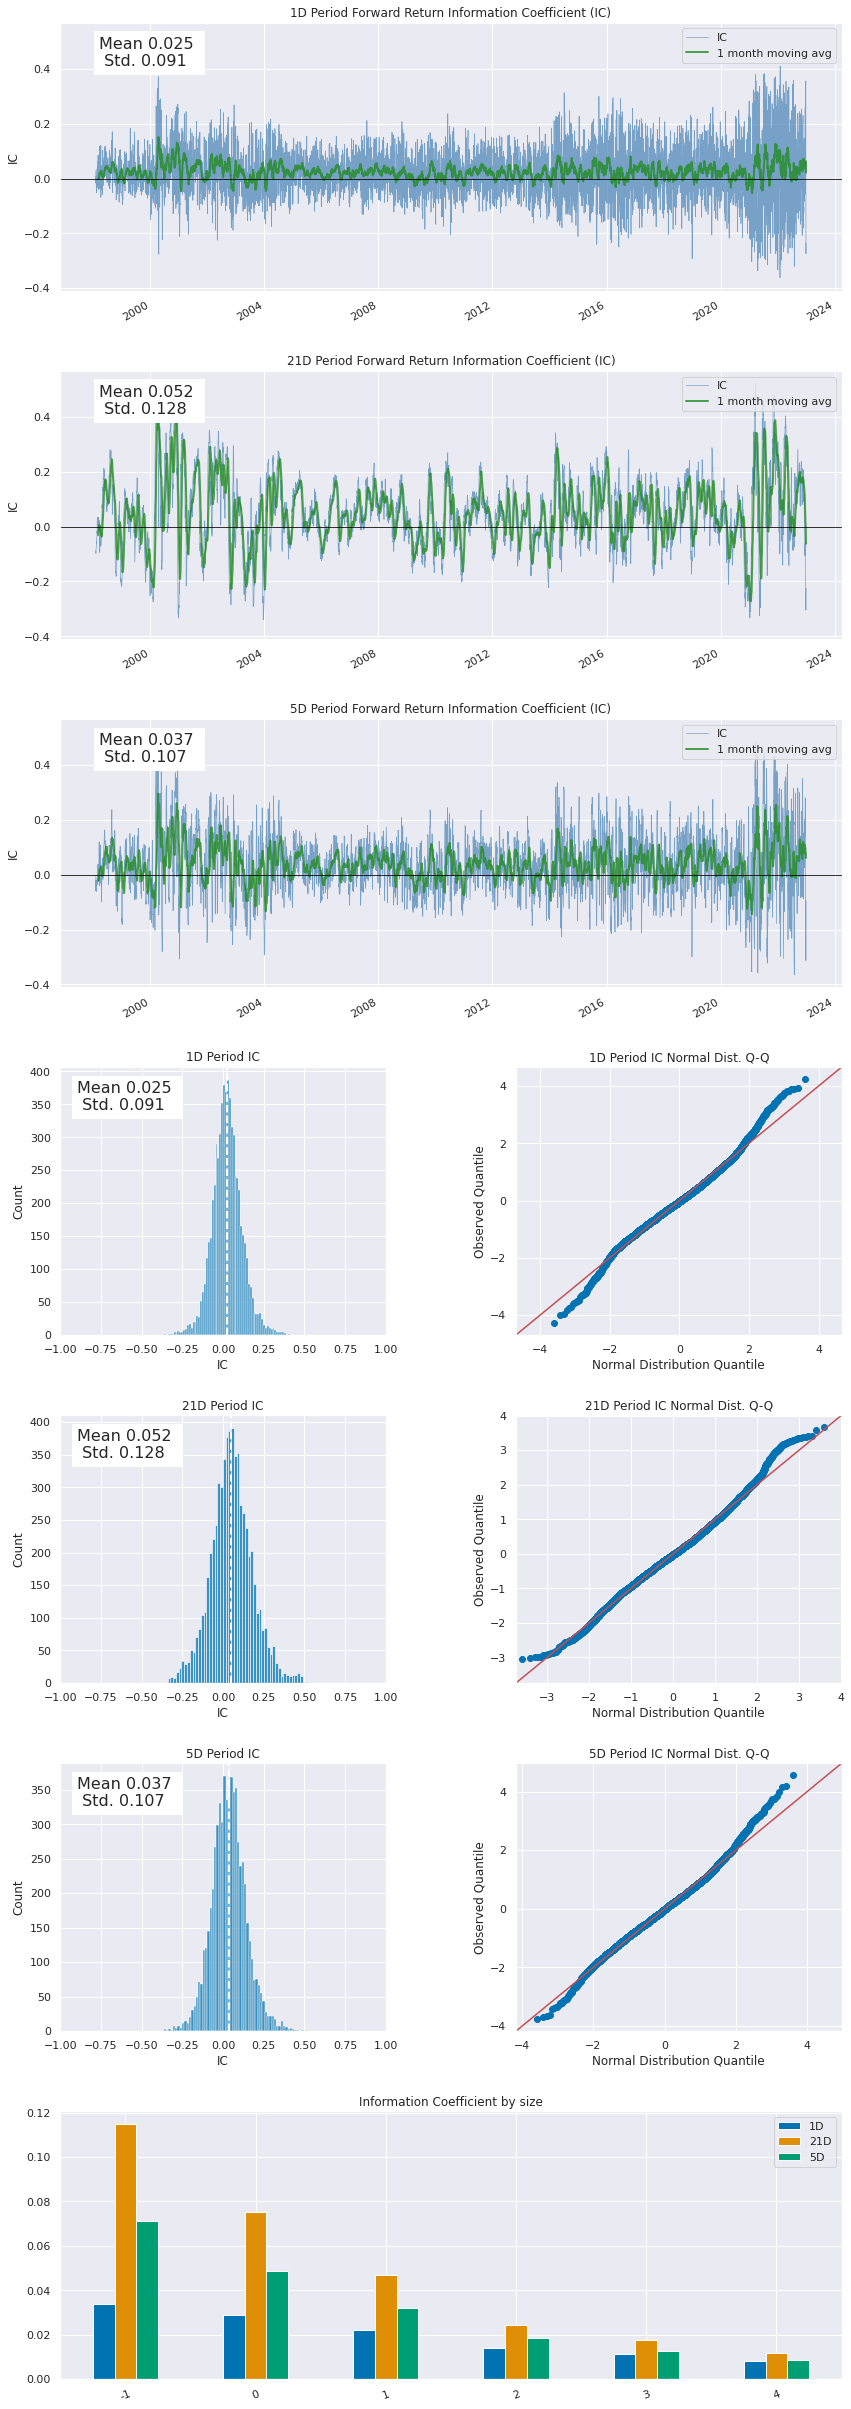

,1D,5D,21D
Quantile 1 Mean Turnover,0.007,0.030,0.104
Quantile 2 Mean Turnover,0.009,0.038,0.135
Quantile 3 Mean Turnover,0.004,0.020,0.071
Quantile 4 Mean Turnover,0.003,0.012,0.041


,1D,21D,5D
Mean Factor Rank Autocorrelation,0.999,0.985,0.996


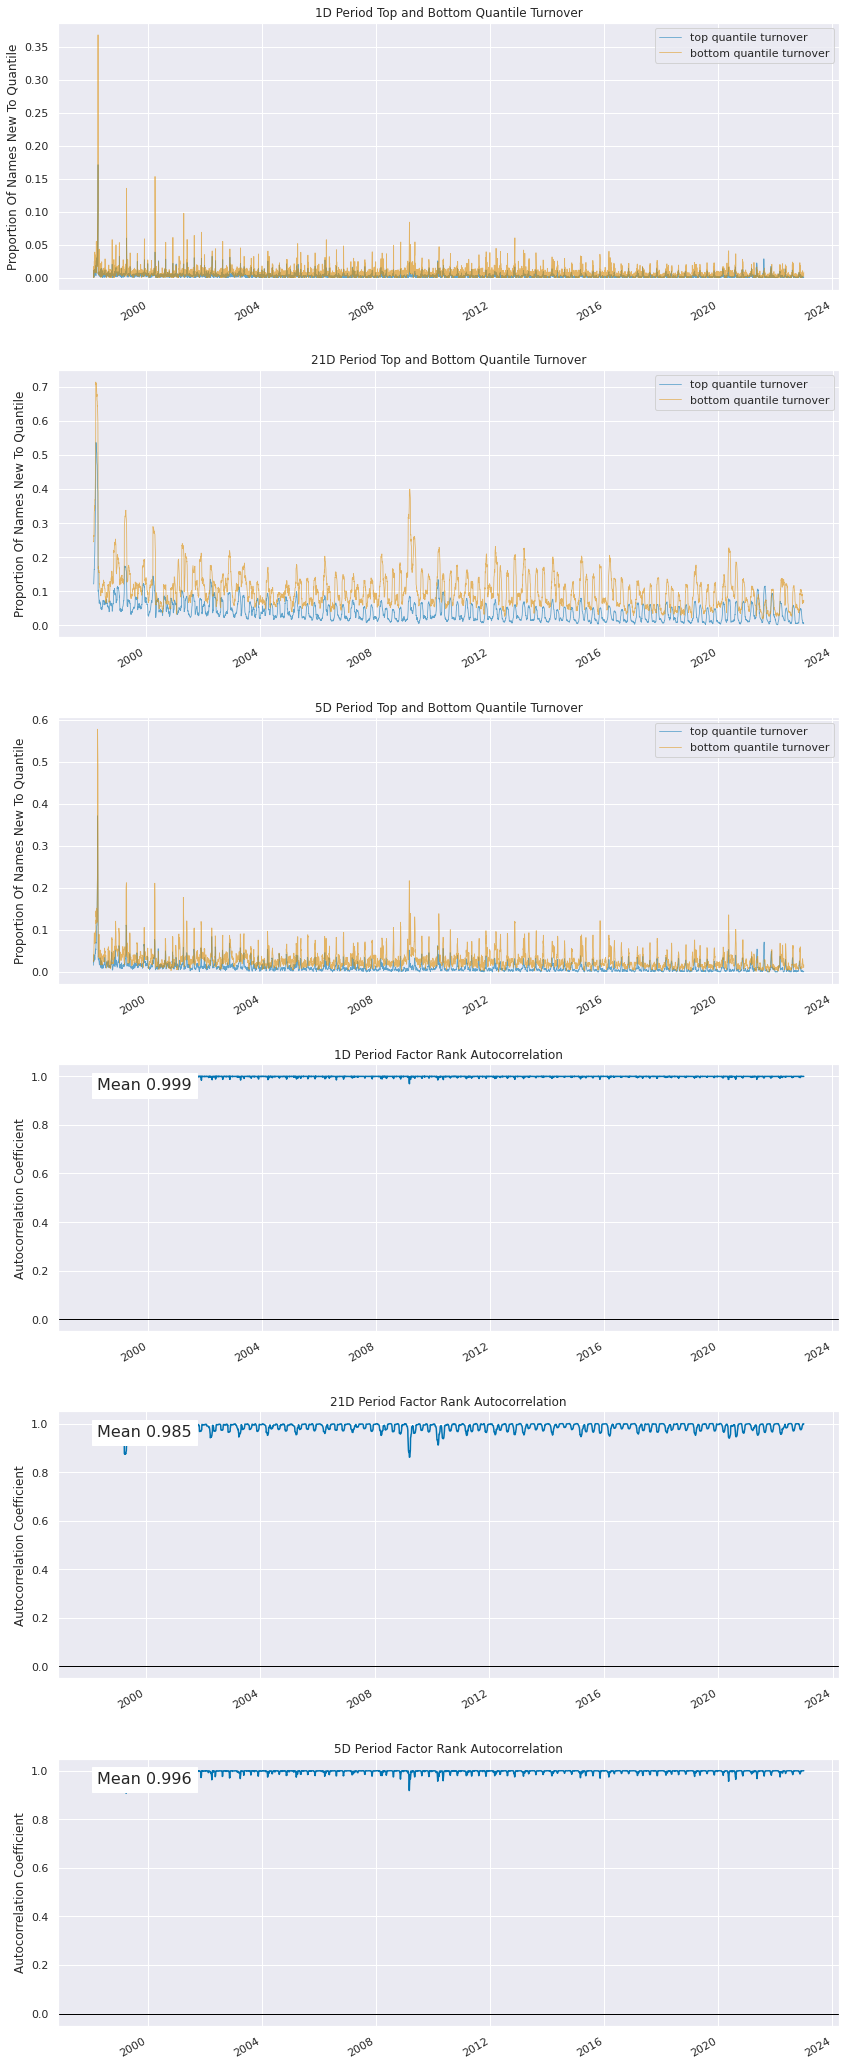

1D  ...  size
date       asset                                    ...      
1998-02-02 Equity(FIBBG000FZXR72 [AAH])   0.003055  ...     1
           Equity(FIBBG000H83MP4 [AAI1])  0.000000  ...     1
           Equity(FIBBG000B9XRY4 [AAPL]) -0.033861  ...     3
           Equity(FIBBG000MDCQC2 [COR])   0.031084  ...     3
           Equity(FIBBG000B9YDD7 [ABF])   0.012302  ...     3
...                                            ...  ...   ...
2022-12-30 Equity(FIBBG0160DYCH4 [RXO])  -0.027699  ...     2
           Equity(FIBBG019QV0CG8 [SNAL]) -0.032895  ...     0
           Equity(FIBBG000BCVMH9 [CP])   -0.010874  ...     4
           Equity(FIBBG000K5M1S8 [ENB])  -0.004329  ...     4
           Equity(FIBBG000C32XT3 [IMO])   0.004534  ...     4

[20198952 rows x 6 columns]

In [4]:
import alphalens as al

al.from_pipeline(
    pipeline,
    start_date="1998-02-01",
    end_date="2022-12-30",
    periods=[1, 5, 21],
    factor="profitability",
    quantiles=4,
    zero_aware=True,
    groupby=[
        "size", 
    ],
    segment="Y"
)

## Tear sheet commentary

### Factor Distribution table

* `min`/`max`: The minimum value in quantile 1 and the maximum value in quantile 4 reflect the fact that we clipped operating margin to a range of (-1, 1).
* `min`/`max`: All values in quantiles 1 and 2 are negative, and all values in quantiles 3 and 4 are positive. This is because we specified `zero_aware=True`.
* `count %`: The negative quantiles (quantiles 1 and 2) are smaller in size than the positive quantiles (quantiles 3 and 4). This tells us that a majority of companies have positive operating margin. (If we did not specify `zero_aware=True`, the quantiles would be equally sized, and some of the positive values would show up in quantile 2.) 

### Returns Analysis

* `Mean Relative Return By Factor Quantile`: higher quantiles (positive operating margins) perform better than lower quantiles (negative operating margins). Most notably, the companies with the most negative operating margins (quantile 1) perform very poorly.
* `Factor-Weighted Long/Short Portfolio Cumulative Return`: this plot reflects a long/short portfolio where we long all stocks with positive operating margins and short all stocks with negative operating margins, with each position's weight being proportional to its factor value. Since we clipped the factor values using `clip()`, this plot is relatively smooth. If you don't clip or winsorize outliers, this plot may show extreme positive or negative performance, reflecting a highly concentrated portfolio.
* `Relative Cumulative Return by Quantile`: this plot shows the relative performance of 4 portfolios formed from the 4 quantiles, with positions being equal-weighted within each portfolio. While quantile 1 (containing companies with the most negative operating margin) performed very poorly over time, it spiked higher during the dotcom bubble of the late 1990s. 
* `Actual Cumulative Return by Quantile`: this plot consists of the same 4 portfolios (1 per quantile) as the previous plot, but now we see their actual returns rather than their relative returns. For example, whereas the previous plot showed a persistent decline in quantile 1 over time, in this plot we see that, since the dotcom crash of 2000-2003, the poor relative performance of quantile 1 is not because companies with negative operating margins have trended lower but rather because they have failed to trend upward along with other companies.
* `Bottom/Top Quantile Composition by size`: these pie charts are included because we specified a `groupby` column. The column was called "size" and reflected a division of the universe into 5 quantiles by market cap. Size quantile 0 contains the smallest companies and size quantile 4 contains the largest companies. The pie charts reveal that small companies (size quantile 0) are over-represented in the bottom factor quantile (that is, the quantile of companies with the most negative operating margin), and large companies (size quantile 4) are over-represented in the top factor quantile (that is, the quantile of companies with the highest operating margins. In other words, larger companies tend to have better operating margins than smaller companies. (The `quantiles()` method in Pipeline uses -1 to categorize NaN values, so the sliver in the pie chart corresponding to -1 indicates that a few stocks in the universe didn't have market cap data.)
* `Mean Relative Return plots by size quantile`: these bar charts show the mean relative return by factor quantile (that is, by operating margin quantile) for each of the size quantiles. These plots allow us to see if the factor behaves differently depending on company size. In the case of operating margin, factor quantile 1 (companies with the most negative operating margins) performs poorly in each of size quantiles 0-4, suggesting that the factor matters regardless of size. (The bar charts for size quantile -1 are best ignored because the preceding plots give us a hint that this size quantile (corresponding to NaN values for market data) has a small sample size.)    

***

## *Next Up*

Lesson 7: [Alphalens: Profitability Growth](Lesson07-Profitability-Growth.ipynb)